# Imports

In [902]:
# Librairies
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [903]:
# URLs
exports = 'D:\Drive\Colab Notebooks\oc\p4\exports\\'
local = 'sources/'
github = 'https://raw.githubusercontent.com/gllmfrnr/oc/master/p4/sources/'

In [904]:
# Dataframes
clients =       pd.read_csv(local + 'customers.csv')
produits =        pd.read_csv(local + 'products.csv')    
transactions =    pd.read_csv(local + 'transactions.csv')

In [905]:
# Styles
# Exemple : print(color.bold + 'Hello' + color.end)
class style:
   blue = '\033[94m'
   green = '\033[92m'
   red = '\033[91m'
   bold = '\033[1m'
   underline = '\033[4m'
   end = '\033[0m' 

indigo_A100 = '#8c9eff'
purple_A100 = '#ea80fc'

## Fonctions

### Exploration

In [906]:
# Vérification et suppression de duplicats
def duplicats(df):
  print(  # Vérifier présence de duplicats
      len(df), 'lignes avant suppression \n' +
      'Nombre de duplicats :', len(df) - len(df.drop_duplicates())    
  )
  df.drop_duplicates(inplace=True)  # Suppression des duplicats
  print(len(df), 'lignes après suppression')

In [907]:
# Exploration des datasets
def exploration(df):
    print( 
        style.red + 'SAMPLE ↓ \n' + style.end,
        df.sample(3), '\n'                                              # Sample
        ) 
    print(style.red + 'INFO ↓ \n' + style.end)
    print(df.info(), '\n')                                              # Colonnes, null-count, types d'objets
    for i in range(0, len(df.columns)):
        print(
            style.red + 'COLONNE',
            style.bold + df.columns[i], ': \n' + style.end,             # Nom de colonne
             df.iloc[:, i].describe(), '\n',                            # .describe()
            sum(df.iloc[:, i].isna()), 'Nan \n',                        # Nbre de Nan 
            df.shape[0] - np.count_nonzero(df.iloc[:, i]), 'zéros \n',  # Nbre de 0
            len(df.iloc[:, i].unique()), 'valeurs uniques : \n'#,
            #df.iloc[:, i].unique(), '\n'                                # Nombre de valeurs uniques 
        )

In [908]:
# Exploration des datasets
def exploration(df):
    print( 
        style.red + 'SAMPLE ↓ \n' + style.end,
        df.sample(3), '\n'                                              # Sample
        ) 
    print(style.red + 'INFO ↓ \n' + style.end)
    print(df.info(), '\n')                                              # Colonnes, null-count, types d'objets
    for i in range(0, len(df.columns)):
        print(
            style.red + 'COLONNE',
            style.bold + df.columns[i], ': \n' + style.end,             # Nom de colonne
             df.iloc[:, i].describe(), '\n',                            # .describe()
            sum(df.iloc[:, i].isna()), 'Nan \n',                        # Nbre de Nan 
            df.shape[0] - np.count_nonzero(df.iloc[:, i]), 'zéros \n',  # Nbre de 0
            len(df.iloc[:, i].unique()), 'valeurs uniques : \n'#,
            #df.iloc[:, i].unique(), '\n'                                # Nombre de valeurs uniques 
        )

In [909]:
# Vérification de la clé primaire
def check_pk(df_pk):
  table_length = len(df_pk) - len(df_pk.drop_duplicates())
  if table_length == 0:
    print(style.green + 'C\'est bien une clé primaire (0 duplicat)' + style.end)
  else:
    print(
        style.red + 'Ce n\'est pas une clé primaire (',
        table_length, 'duplicats )' + style.end
        )

### Indicateurs

In [910]:
# Indicateurs univariés

def indicateurs(df, variable):
    
    # Paramètres de position
    mode = df[variable].mode().to_list()
    frequence_mode = round((len(df[df[variable]==mode[0]]) / len(df) * 100), 1)
    moyenne = round(df[variable].mean(), 1)
    mediane = df[variable].median()
    quartile_1 = round(df[variable].quantile(0.25), 1)
    quartile_3 = round(df[variable].quantile(0.75), 1)
      
    # Paramètres de dispersion
    minimum = df[variable].min()
    maximum = df[variable].max()
    etendue = round((maximum - minimum), 1)
    variance = round(df[variable].var(ddof=0), 1)
    ecart_type = round(df[variable].std(ddof=0), 1)
    coeff_variation = round(df[variable].std(ddof=0) / df[variable].mean(), 1)
    
    skewness = round(df[variable].skew(), 1)
    if skewness > 0:
        skewness_symetrie = 'étalée à droite'
    elif skewness < 0:
        skewness_symetrie = 'étalée à gauche'
    else:
        skewness_symetrie = 'symétrique'
        
    kurtosis = round(df[variable].kurtosis(), 1)
    if kurtosis > 0:
        kurtosis_aplatissement = 'moins aplatie que la normale gaussienne'
    elif kurtosis < 0:
        kurtosis_aplatissement = 'plus aplatie que la normale gaussienne'
    else:
        kurtosis_aplatissement = 'normale (gaussienne)'
        
    # Affichage
    print(
        style.bold + 'Indicateurs de position :' + style.end,
        '\nMode(s) :', mode, '(fréquence :', frequence_mode, '%)',        
        '\nMoyenne :', moyenne, '\nMédiane :', mediane,
        '\n1er quartile :', quartile_1, '\n3ème quartile :', quartile_3,
        
        style.bold + '\nIndicateurs de dispersion :' + style.end,
        '\nMinimum :', minimum, '\nMaximum :', maximum, '\nÉtendue :', etendue,
        '\nVariance :', variance, '\nÉcart-type : ', ecart_type,
        '\nCoeff. de variation :', coeff_variation,
        '\nSkewness :', skewness, '( distribution', skewness_symetrie, ')',
        '\nKurtosis :', kurtosis, '( distribution', kurtosis_aplatissement, ')'
    )

In [911]:
# Indicateurs bivariés
def indicateurs_bivaries(df, variable_1, variable_2):
    for mode in df[variable_1].unique():
        subset = df[df[variable_1] == mode]
        print(
            style.bold + style.blue + 'Modalité :' + style.end, mode,
            '(fréquence :', round((len(subset) / len(df) * 100), 1), '%)\n'
        ),
        indicateurs(subset, variable_2), 
        print('\n')

In [912]:
#???????????????????????????????????????????????????????????????????
#???????????????????????????????????????????????????????????????????
#???????????????????????????????????????????????????????????????????

# Courbe de Lorenz et indice de Gini
def lorenz(observations):

  # Nombre d'observations
  n = len(observations)

  # LORENZ ↓↓

  #   ↓ Définir ordonnées
  #   Trier les individus par ordre croissant : np.sort()
  #   Calculer la somme cumulée : np.cumsum()
  #   Normaliser en divisant par la somme totale des observations : / .sum()
  lorenz = np.cumsum(np.sort(observations)) / observations.sum()
  #   La courbe de Lorenz débute à 0 (ajouter valeur 0 avant liste précédente)
  lorenz = np.append([0], lorenz)

  #   ↓ Définir ordonnées, de 0 à 1 à intervalles réguliers
  xaxis = np.linspace(0-1 / n, 1+1 / n, n+1)

  # GINI
  #     Surface sous la courbe de Lorenz
  AUC = (lorenz.sum() - lorenz[-1]/2 -lorenz[0]/2) / n
  #     Surface entre la 1ère bissectrice et la courbe de Lorenz
  S = 0.5 - AUC
  gini = 2*S

  # Afficher la courbe
  plt.axes().axis('equal')
  plt.plot(xaxis, lorenz, drawstyle='steps-post')
  plt.ylim([0,1])
  plt.show()

  print('Indice de Gini :', round(gini, 1))

# Exploration

## Suppression des duplicats
- On vérifie ces duplicats avant l'exploration, pour permettre de définir les clés primaires
- Seule la table **transactions** contient des duplicats, qu'on supprime

In [913]:
# customers
duplicats(clients)

# --> Aucun duplicat

8623 lignes avant suppression 
Nombre de duplicats : 0
8623 lignes après suppression


In [914]:
# products
duplicats(produits)

# --> Aucun duplicat

3287 lignes avant suppression 
Nombre de duplicats : 0
3287 lignes après suppression


In [915]:
# transactions
duplicats(transactions)

# --> Présence de 126 duplicats, on les supprime

337016 lignes avant suppression 
Nombre de duplicats : 126
336890 lignes après suppression


## Clients
- 3 variables : *'client_id'*, *'Sexe'* et *'Naissance'*
- 2 modalités dans *'Sexe'* : f ou h
- Dans *'Naissance'*, années s'étalant de 1929 à 2004
- Aucune valeur manquante ou aberrante
- Aucun doublon dans *'client_id'*
- Clé primaire : *'client_id'*

In [916]:
# Renommer les colonnes
clients.rename(columns={'sex': 'Sexe', 'birth': 'Naissance'}, inplace=True)
clients.sample(5)

,client_id,Sexe,Naissance
3049,c_1429,f,1985
3361,c_1484,f,1960
2929,c_883,f,1993
2746,c_7451,f,1965
5614,c_1807,m,1993


In [917]:
# Exploration du dataset
# exploration(clients)

# --> Aucun doublon dans la variable 'client_id'
# --> 2 valeurs possibles dans 'sex' : f ou m
# --> Valeurs de 1929 à 2004 dans 'birth'
# --> Aucune valeur manquante
# --> Aucune valeur aberrante

In [918]:
# Vérification de la clé primaire
check_pk(clients['client_id'])

C'est bien une clé primaire (0 duplicat)


## Produits
- 3 variables : *'id_prod'*, *'Prix'* et *'Catégorie'*
- 3 modalités dans *'Catégorie'* : 0, 1 et 2
- Valeurs aberrantes dans *'Prix'* (car inférieures à 0)
- Aucune valeur manquante
- Aucun doublon dans *'id_prod'*
- Clé primaire : *'id_prod'*

In [919]:
# Renommer les colonnes
produits.rename(columns={'price': 'Prix', 'categ': 'Catégorie'}, inplace=True)
produits.sample(5)

,id_prod,Prix,Catégorie
1921,1_96,7.58,1
1761,1_267,27.99,1
1447,1_187,26.99,1
75,0_2035,17.99,0
2349,0_503,18.99,0


In [920]:
# Exploration du dataset
#exploration(produits)

# --> Aucun doublon dans la variable 'id_prod'
# --> Valeurs aberrantes dans 'price' (inférieures à 0)
# --> 3 valeurs possibles dans 'categ' : 0, 1, 2
# --> Aucune valeur manquante

In [921]:
# Vérification de la clé primaire
check_pk(produits['id_prod'])

C'est bien une clé primaire (0 duplicat)


## Transactions
- 4 variables : *'id_prod'*, *'Date'*, *'session_id'* et *'client_id'*
- *'id_prod'* et *'client_id'* sont des clés étrangères vers **produits** et **clients**
- Il y a moins de valeurs uniques dans ces variables que dans les tables qu'elles référencent (certains clients n'ont pas passé commande, certains produits n'ont pas été vendus)
- Valeurs aberrantes dans *'Date'* (dates ayant 'test_' pour préfixe')
- Aucune valeur manquante

In [922]:
# Renommer les colonnes
transactions.rename(columns={'date': 'Date'}, inplace=True)
transactions.sample(5)

,id_prod,Date,session_id,client_id
260761,1_466,2021-06-21 19:17:35.807244,s_51861,c_3752
73535,0_1399,2021-08-23 12:29:50.641354,s_79620,c_6912
186876,1_683,2021-05-17 09:03:03.167377,s_35655,c_1016
43002,1_498,2021-12-18 19:11:49.985515,s_136372,c_3500
244202,0_1612,2021-12-14 15:26:46.308807,s_134295,c_6819


In [923]:
# Exploration du dataset
#exploration(transactions)

# --> id_prod et client_id sont des clés étrangères vers products et customers
# --> Moins de valeurs uniques dans ces variables que dans celles des tables référencées
# --> Aucune valeur manquante

In [924]:
# Vérification de la clé primaire
check_pk(transactions[['Date', 'client_id']])

C'est bien une clé primaire (0 duplicat)


## Data (jointures)
- **transactions** contient moins de clés dans les variables référençant **clients** et **produits** (respectivement *'client_id'* et *'id_prid'*) : on ne préserve que les clés de **transactions**, dans une nouvelle table appelée **data**
- à l'issue des jointures, des valeurs manquantes apparaissent dans *'Prix'* et *'Catégorie'* (103 NaN pour chacune des 2 variables)

In [925]:
# Jointure externe gauche entre transactions et customers
data = pd.merge(transactions, clients, how='left', on='client_id')

# Jointure externe gauche avec products à droite
data = pd.merge(data, produits, how='left', on='id_prod')

data

,id_prod,Date,session_id,client_id,Sexe,Naissance,Prix,Catégorie
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,4.99,0.0
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,f,2000,65.75,2.0
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,f,1979,10.71,1.0
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,m,1963,4.20,0.0
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,f,1980,8.99,0.0
...,...,...,...,...,...,...,...,...
336885,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,m,1969,31.99,1.0
336886,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,m,1991,22.99,0.0
336887,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,f,1968,11.03,0.0
336888,2_227,2021-10-30 16:50:15.997750,s_112349,c_5,f,1994,50.99,2.0


In [926]:
# Exploration du dataset
# exploration(data)

# --> Des valeurs manquantes apparaissent dans 'price' et 'categ' (même nombre : 103)

# Nettoyage

## Valeurs aberrantes
- *'Prix'* et *'Date'* contiennent chacune 74 valeurs aberrantes
- Ces valeurs concernent les 74 mêmes lignes
- Toutes sont des tests menés en interne : on les supprime

In [927]:
# 'Prix' contient 74 valeurs aberrantes
data.sort_values(by=['Prix']).head(77)

# --> La seule valeur aberrante est -1

,id_prod,Date,session_id,client_id,Sexe,Naissance,Prix,Catégorie
109577,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1,m,2001,-1.00,0.0
59039,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0,f,2001,-1.00,0.0
47169,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_1,m,2001,-1.00,0.0
129823,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0,f,2001,-1.00,0.0
151885,T_0,test_2021-03-01 02:30:02.237435,s_0,ct_1,m,2001,-1.00,0.0
...,...,...,...,...,...,...,...,...
317233,T_0,test_2021-03-01 02:30:02.237448,s_0,ct_0,f,2001,-1.00,0.0
137476,T_0,test_2021-03-01 02:30:02.237432,s_0,ct_0,f,2001,-1.00,0.0
57641,0_528,2021-06-24 18:55:00.312636,s_53240,c_5636,f,1989,0.62,0.0
25621,0_202,2021-05-14 15:26:20.597059,s_34456,c_5510,f,1941,0.62,0.0


In [928]:
# Nombre d'occurences de la valeur -1 dans 'price'
print(
    'La valeur -1 est présente',
    len(data[data['Prix'] == -1]),
    'fois dans la variable \'Prix\''
    )

La valeur -1 est présente 74 fois dans la variable 'Prix'


In [929]:
# Les dernières valeurs de 'Date' ont pour préfixe 'test_'
data.sort_values(by=['Date']).tail(3)

,id_prod,Date,session_id,client_id,Sexe,Naissance,Prix,Catégorie
203184,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_0,f,2001,-1.0,0.0
245271,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1,m,2001,-1.0,0.0
38778,T_0,test_2021-03-01 02:30:02.237450,s_0,ct_0,f,2001,-1.0,0.0


In [930]:
# Nombre d'occurences du préfixe 'test_'
print(
    'Il y a',
    data['Date'].str.contains('test_').value_counts().tolist()[1],
    'dates ayant \'test_\' pour préfixe'
    )

Il y a 74 dates ayant 'test_' pour préfixe


In [931]:
lignes_test = data[(data['Prix'] == -1) & (data['Date'].str.contains('test_'))]
lignes_test

# --> La combinaison des 2 valeurs aberrantes renvoie bien aux mêmes 74 lignes

,id_prod,Date,session_id,client_id,Sexe,Naissance,Prix,Catégorie
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1,m,2001,-1.0,0.0
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1,m,2001,-1.0,0.0
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1,m,2001,-1.0,0.0
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0,f,2001,-1.0,0.0
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1,m,2001,-1.0,0.0
...,...,...,...,...,...,...,...,...
264229,T_0,test_2021-03-01 02:30:02.237416,s_0,ct_1,m,2001,-1.0,0.0
288815,T_0,test_2021-03-01 02:30:02.237415,s_0,ct_1,m,2001,-1.0,0.0
293003,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_0,f,2001,-1.0,0.0
298292,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1,m,2001,-1.0,0.0


In [932]:
# Nombre de lignes dans le dataset
len_data_before = len(data)

# Supprimer les lignes test via leur index
data.drop(lignes_test.index, inplace=True)

# Nombre de lignes dans le dataset après nettoyage
print(len_data_before - len(data), 'lignes supprimées')

74 lignes supprimées


In [933]:
# Type de la variable 'date' avant conversion 
print(
    style.bold + 'Type de la variable date :\n' + style.end +
    'Avant conversion :', type(data['Date'].loc[0])
)

# Conversion de la variable 'date' en datetime
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Type, après conversion
print('Après conversion :', type(data['Date'].loc[0]))

Type de la variable date :
Avant conversion : <class 'str'>
Après conversion : <class 'pandas._libs.tslibs.timestamps.Timestamp'>


## Valeurs manquantes : NaN 

### Identification
- *'Catégorie'* et *'Prix'* contiennent 103 valeurs manquantes
- Toutes sont communes à 103 lignes référençant un produit unique : 0_2245
- Ces lignes représentent 0.03% du dataset : on pourrait les supprimer sans fausser les analyses
- On va tout de même tenter de remplacer les valeurs manquantes, en créant au préalable un sous-échantillon ne contenant que le produit 0_2245 

In [934]:
# Vérification de la présence de NaN dans les colonnes 'categ' et 'price'
# Et identification du produit concerné
def verif_nan(colonne):
  # Lignes ayant une valeur nulle dans 'colonne'
  null = data[data[colonne].isnull()]
  print(
    'Il y a', len(null), 'lignes n\'ayant pas de valeur dans \'' + colonne + '\' :',
    'toutes ont', null['id_prod'].unique(), 'pour \'id_prod\''
  )

verif_nan('Catégorie')
verif_nan('Prix')

Il y a 103 lignes n'ayant pas de valeur dans 'Catégorie' : toutes ont ['0_2245'] pour 'id_prod'
Il y a 103 lignes n'ayant pas de valeur dans 'Prix' : toutes ont ['0_2245'] pour 'id_prod'


In [935]:
# Sous-échantillon ne contenant que le produit '0_2245'
subset_2245 = data[data['id_prod']=='0_2245']
subset_2245

,id_prod,Date,session_id,client_id,Sexe,Naissance,Prix,Catégorie
6235,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533,m,1972,NaN,NaN
10802,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954,m,1973,NaN,NaN
14051,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120,f,1975,NaN,NaN
17486,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964,f,1982,NaN,NaN
21078,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,m,1988,NaN,NaN
...,...,...,...,...,...,...,...,...
322597,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167,f,1979,NaN,NaN
329300,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790,f,1983,NaN,NaN
330371,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189,f,1984,NaN,NaN
335405,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595,f,1973,NaN,NaN


In [936]:
print(
    'Ce sous-échantillon représente',
    round((len(subset_2245) / len(data) * 100), 2),
    '% de la population totale'
)

Ce sous-échantillon représente 0.03 % de la population totale


### Indicateurs : sous-échantillon
- Les variables *'id_prod'*, *'session_id'* et *'client_id'* ne peuvent pas aider à déterminer les valeurs manquantes
- Les modalités des variables *'Date'* et *'Sexe'* sont distribuées uniformément : on ne peut pas se baser sur leurs indicateurs non plus
- La variable *'Naissance'* affiche une fréquence de mode significative (8.7% pour l'année 1978) : on retient cet indicateur, dont on va rechercher les valeurs correspondantes dans la population totale

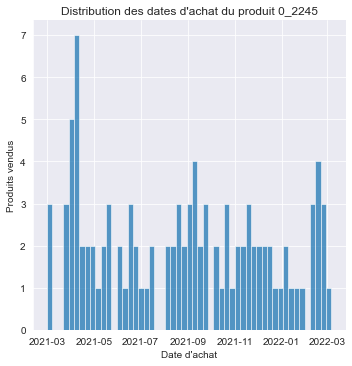

In [937]:
g = sns.displot(
    subset_2245, 
    x="Date",
    binwidth=7, # (1 classe = 1 semaine)
    #element='step'
    )
g = (g.set_axis_labels(
    'Date d\'achat',
    'Produits vendus'
))
plt.title('Distribution des dates d\'achat du produit 0_2245')
plt.show(g)

# --> Les dates sont assez normalement réparties sur toutes l'année
# --> On ne peut pas se baser sur la date pour déterminer les données manquantes

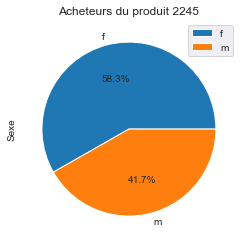

In [938]:
# Proportion des modalités de la variable 'Sexe' dans le sous-échantillon
a = subset_2245['Sexe'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%'
)
a.set(ylabel='Sexe')
plt.title('Acheteurs du produit 2245')
plt.show(a)

# --> Presqu'autant d'hommes que de femmes ont acheté ce produit
# --> L'écart n'est pas assez net pour qu'on détermine des données à partir de cette variable

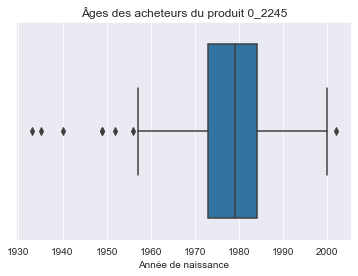

In [939]:
# Box plot sur 'Naissance'
c = sns.boxplot(data=subset_2245, x='Naissance')
c.set(xlabel='Année de naissance')
plt.title('Âges des acheteurs du produit 0_2245')
plt.show(c)

In [940]:
# Indicateurs de la variable 'Naissance'
indicateurs(subset_2245, 'Naissance')

# --> 8% des acheteurs de ce produit sont nés en 1978
# --> Le pourcentage est significatif, vu la taille limitée de l'échantillon
# --> On peut tenter de déterminer 'Catégorie' et 'Prix' à partir de 'Naissance'

Indicateurs de position : 
Mode(s) : [1978] (fréquence : 8.7 %) 
Moyenne : 1977.3 
Médiane : 1979.0 
1er quartile : 1973.0 
3ème quartile : 1984.0 
Indicateurs de dispersion : 
Minimum : 1933 
Maximum : 2002 
Étendue : 69 
Variance : 137.4 
Écart-type :  11.7 
Coeff. de variation : 0.0 
Skewness : -1.5 ( distribution étalée à gauche ) 
Kurtosis : 3.5 ( distribution moins aplatie que la normale gaussienne )


### Indicateurs : population totale
- L'année 1978 se situe dans le deuxième quartile de la population totale, et à la limite du 3ème : on vérifiera les indicateurs de ces 2 tranches
- Le mode de *'Catégorie'* pour ces 2 quartiles est 0 (fréquences supérieures à 70%) : on retient donc cette valeur

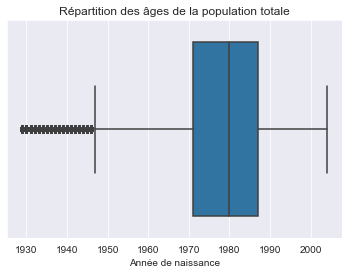

In [941]:
# Indicateurs de position de la variable 'Naissance'
c = sns.boxplot(data=data, x='Naissance')
c.set(xlabel='Année de naissance')
plt.title('Répartition des âges de la population totale')
plt.show(c)

# --> Les clients du produit 0_2245 appartiennent à l'espace entre Q1 et la médiane
# --> Ils sont situés à la limite de la médiane (analyser l'espace entre Q2 et Q3)

In [942]:
# Découpage de la population en 4 quartiles de la variable 'Naissance'
quartile_1 = data[data['Naissance'] < data['Naissance'].quantile(.25)]
quartile_2 = data[
    (data['Naissance'] >= data['Naissance'].quantile(.25))
    & (data['Naissance'] < data['Naissance'].quantile(.5))
]
quartile_3 = data[
    (data['Naissance'] >= data['Naissance'].quantile(.5))
    & (data['Naissance'] < data['Naissance'].quantile(.75))
]
quartile_4 = data[data['Naissance'] >= data['Naissance'].quantile(.75)]

# Ajout d'une colonne indiquant la tranche d'âge
data['Tranche âge'] = ''
data['Tranche âge'].loc[quartile_1.index] = 'A'
data['Tranche âge'].loc[quartile_2.index] = 'B'
data['Tranche âge'].loc[quartile_3.index] = 'C'
data['Tranche âge'].loc[quartile_4.index] = 'D'

data.sample(5)

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,id_prod,Date,session_id,client_id,Sexe,Naissance,Prix,Catégorie,Tranche âge
110183,0_1503,2021-09-17 10:03:59.917194,s_91205,c_2940,f,1982,15.99,0.0,C
77939,0_1430,2021-05-10 08:40:05.141791,s_32476,c_798,m,1985,16.47,0.0,C
119678,2_39,2021-12-12 08:56:52.764308,s_133190,c_6714,f,1968,57.99,2.0,A
127937,0_1339,2021-05-14 12:00:04.914477,s_34384,c_682,f,1974,8.99,0.0,B
200568,0_1440,2021-03-05 14:55:00.444866,s_2141,c_2020,f,1973,5.62,0.0,B


In [943]:
# Indicateurs de catégorie du 2ème quartile de 'Naissance'
print(style.bold + style.green + 'Sous-échantillon : 2ème quartile de \'Naissance\'\n' + style.end)
print(style.underline + style.red + 'Catégorie :' + style.end)
indicateurs(quartile_2, 'Catégorie')

# Indicateurs de catégorie du 3ème quartile de 'Naissance'
print('\n\n' + style.bold + style.green + 'Sous-échantillon : 3ème quartile de \'Naissance\'\n' + style.end)
print(style.underline + style.red + 'Catégorie :' + style.end)
indicateurs(quartile_3, 'Catégorie')

# --> Pour 'Catégorie', la fréquence du mode est significative, et correspond à la médiane
# --> L'indicateur est quasiment le même pour le 2ème et le 3ème quartile
# --> On retient la catégorie 0 pour cette tranche d'âge

Sous-échantillon : 2ème quartile de 'Naissance'

Catégorie :
Indicateurs de position : 
Mode(s) : [0.0] (fréquence : 75.0 %) 
Moyenne : 0.3 
Médiane : 0.0 
1er quartile : 0.0 
3ème quartile : 1.0 
Indicateurs de dispersion : 
Minimum : 0.0 
Maximum : 2.0 
Étendue : 2.0 
Variance : 0.2 
Écart-type :  0.4 
Coeff. de variation : 1.7 
Skewness : 1.2 ( distribution étalée à droite ) 
Kurtosis : -0.2 ( distribution plus aplatie que la normale gaussienne )


Sous-échantillon : 3ème quartile de 'Naissance'

Catégorie :
Indicateurs de position : 
Mode(s) : [0.0] (fréquence : 77.1 %) 
Moyenne : 0.2 
Médiane : 0.0 
1er quartile : 0.0 
3ème quartile : 0.0 
Indicateurs de dispersion : 
Minimum : 0.0 
Maximum : 2.0 
Étendue : 2.0 
Variance : 0.2 
Écart-type :  0.4 
Coeff. de variation : 1.8 
Skewness : 1.4 ( distribution étalée à droite ) 
Kurtosis : 0.2 ( distribution moins aplatie que la normale gaussienne )


### Corrélation entre *'Catégorie'* et *'Prix'*
- Les 3 catégories sont corrélées à la variable *'Prix'*, chacune correspondant plus ou moins à une tranche de valeurs (le 1er caractère des valeurs de *'id_prod'* est d'ailleurs égal à *'Catégorie'*)
- Pour la catégorie 0, les indicateurs de *'Prix'* sont quasiment identiques entre les 2 quartiles d'âges
- La fréquence de leur mode (4%) est insuffisante : on retient donc la médiane, 9.99 (valeur identique pour l'ensemble de la population)

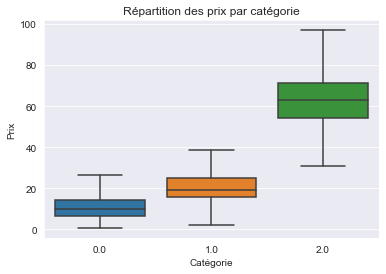

In [944]:
# Corrélation entre 'Catégorie' et 'Prix'
f = sns.boxplot(
    data=data, 
    x='Catégorie', 
    y='Prix',
    showfliers=False # Cacher les outliers pour une meilleure visibilité
)
plt.title('Répartition des prix par catégorie')
plt.show(f)

# --> La catégorie est corrélée au prix
# --> Les catégories correspondent à 3 gammes de prix ordonnées

In [945]:
# Dataframe-test
data_test = data.dropna()

# Réduction de la variable 'id_prod' à 2 caractères
data_test['id_prod'] = data_test['id_prod'].str[:2]

# Valeurs uniques pour chaque catégorie dans 'id_prod'
for i in data_test['Catégorie'].unique():
    print(
        'Valeur unique dans', i, ':',
        data_test[data_test['Catégorie']==i]['id_prod'].unique()
    )

# Les préfixes des identifiants produits correspondent à leur catégorie

Valeur unique dans 0.0 : ['0_']
Valeur unique dans 2.0 : ['2_']
Valeur unique dans 1.0 : ['1_']


<ipython-input-945-8234b3b5a788>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['id_prod'] = data_test['id_prod'].str[:2]


In [946]:
# Indicateurs de 'Prix' pour la modalité 0 de 'Catégorie', dans le 2ème quartile d'âge
print(
    style.bold + style.green + 'Sous-échantillon : 2ème quartile de \'Naissance\'' + style.end,
    style.underline + style.red + '\nIndicateurs de \'Prix\' pour la catégorie 0\n' + style.end
)
indicateurs(quartile_2[quartile_2['Catégorie']==0], 'Prix')

# Indicateurs de 'Prix' pour la modalité 0 de 'Catégorie', dans le 3ème quartile d'âge
print(
    style.bold + style.green + '\n\nSous-échantillon : 3ème quartile de \'Naissance\'' + style.end,
    style.underline + style.red + '\nIndicateurs de \'Prix\' pour la catégorie 0\n' + style.end
)
indicateurs(quartile_3[quartile_3['Catégorie']==0], 'Prix')

# --> La fréquence du mode pour 'price' (4.5%) n'est pas significative, vu la taille de l'échantillon
# --> On retient la médiane (9.99) comme prix

Sous-échantillon : 2ème quartile de 'Naissance' 
Indicateurs de 'Prix' pour la catégorie 0

Indicateurs de position : 
Mode(s) : [4.99] (fréquence : 4.5 %) 
Moyenne : 10.6 
Médiane : 9.99 
1er quartile : 6.2 
3ème quartile : 14.4 
Indicateurs de dispersion : 
Minimum : 0.62 
Maximum : 40.99 
Étendue : 40.4 
Variance : 24.2 
Écart-type :  4.9 
Coeff. de variation : 0.5 
Skewness : 0.4 ( distribution étalée à droite ) 
Kurtosis : -0.4 ( distribution plus aplatie que la normale gaussienne )


Sous-échantillon : 3ème quartile de 'Naissance' 
Indicateurs de 'Prix' pour la catégorie 0

Indicateurs de position : 
Mode(s) : [4.99] (fréquence : 4.4 %) 
Moyenne : 10.7 
Médiane : 9.99 
1er quartile : 6.3 
3ème quartile : 14.4 
Indicateurs de dispersion : 
Minimum : 0.62 
Maximum : 39.99 
Étendue : 39.4 
Variance : 24.3 
Écart-type :  4.9 
Coeff. de variation : 0.5 
Skewness : 0.4 ( distribution étalée à droite ) 
Kurtosis : -0.4 ( distribution plus aplatie que la normale gaussienne )


In [947]:
# Vérification de la médiane de prix de la catégorie 0, sur toute la population
print(
    'Prix médian de la catégorie 0, sur la population totale :',
    data[data['Catégorie']==0]['Prix'].median()
)

# --> La médiane de prix correpond à celles des 2 quartiles étudiés

Prix médian de la catégorie 0, sur la population totale : 9.99


### Remplacement des valeurs

In [948]:
# Remplacement des valeurs manquantes du produit 0_2245
data['Catégorie'].replace(np.nan, 0, inplace=True)
data['Prix'].replace(np.nan, 9.99, inplace=True)

# Affichage du produit 0_2245
data[data['id_prod']=='0_2245']

,id_prod,Date,session_id,client_id,Sexe,Naissance,Prix,Catégorie,Tranche âge
6235,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533,m,1972,9.99,0.0,B
10802,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954,m,1973,9.99,0.0,B
14051,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120,f,1975,9.99,0.0,B
17486,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964,f,1982,9.99,0.0,C
21078,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,m,1988,9.99,0.0,D
...,...,...,...,...,...,...,...,...,...
322597,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167,f,1979,9.99,0.0,B
329300,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790,f,1983,9.99,0.0,C
330371,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189,f,1984,9.99,0.0,C
335405,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595,f,1973,9.99,0.0,B


## Valeurs manquantes : dates
- Plusieurs semaines du mois d'octobre n'affichent aucun individu pour la catégorie 1
- On met de côté les transactions du mois d'octobre (toutes catégories confondues), pour ne pas fausser les analyses

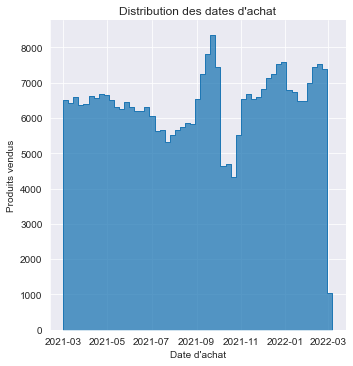

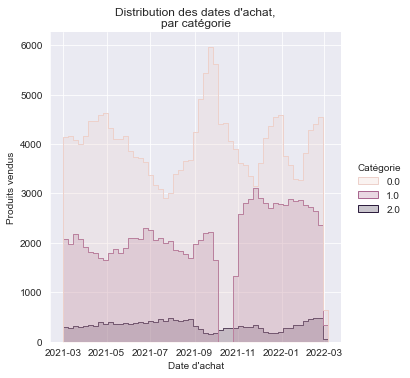

In [949]:
# Distribution des dates d'achats
g = sns.displot(
    data, 
    x="Date",
    binwidth=7, # (1 classe = 1 semaine)
    element='step'
    )
g = (g.set_axis_labels(
    'Date d\'achat',
    'Produits vendus'
))
plt.title('Distribution des dates d\'achat')
plt.show(g)

# Distribution des dates d'achats, par catégorie
g = sns.displot(
    data, 
    x="Date",
    hue='Catégorie', 
    binwidth=7, # (1 classe = 1 semaine)
    element='step'
    )
g = (g.set_axis_labels(
    'Date d\'achat',
    'Produits vendus'
))
plt.title('Distribution des dates d\'achat,\npar catégorie')
plt.show(g)

# --> Il manque des dates au mois d'octobre pour la catégorie 1
# --> On va éliminer les transactions des autres catégories pour le mois d'octobre

In [950]:
# Nombre de lignes avant suppression
len_before = len(data)
print('Nombre de lignes avant suppression :', len_before)

# Suppression des valeurs du mois d'octobre, toutes catégories confondues
data.drop(data[data['Date'].dt.month==10].index, inplace=True)

# Nombre de lignes après suppression
len_after = len(data)
print(
    'Nombre de lignes après suppression :', len_after, '\n',
    round(((len_before - len_after) / len_before * 100), 1),
    '% du dataset écarté'
)

Nombre de lignes avant suppression : 336816
Nombre de lignes après suppression : 315232 
 6.4 % du dataset écarté


# Analyse : axe produits

## Catégories
- Les catégories correspondent à 3 gammes de prix ordonnées :
    - Catégorie 0 : livres les moins chers (médiane à 10, écart-type de 7.5)
    - Catégorie 1 : prix intermédiaires (moyenne et médiane vers 20, écart-type égal à celui de la catégorie 0)
    - Catégorie 2 : prix supérieurs (indicateurs autour de 70, avec un écart-type de 40)
- Le volume des transactions est de 60% pour la catégorie 0, et seulement 5% pour la catégorie 2
- La proportion du stock pour chaque catégorie (**produits**) diffère de celle des transactions enregistrées pour chacune :
    - Catégorie 0 : 70% du stock, 60% des ventes, 80% des références invendues
    - Catégorie 1 : 23% du stock, 35% des ventes, 8% des invendus
    - Catégorie 2 : 7% du stock, 5% des ventes, 12% des invendus
- Proportionnellement au stock, la catégorie 1 rencontre le plus de succès, et affiche le moins d'invendus
- Le prix médian de toutes les transactions est de 13.99 (correspond à l'écart-type supérieur de la cat. 0, et l'écart-type inférieur de la cat. 1) 

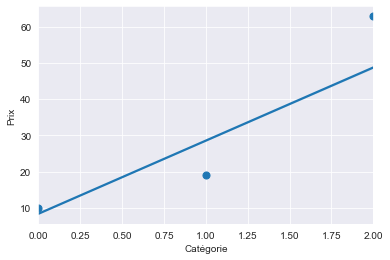

In [951]:
# Régression linéaire
g = sns.regplot(
    data=data, 
    x="Catégorie",
    y='Prix',
    x_estimator=np.median
    )

plt.show(g)

# --> La catégorie est corrélée au prix

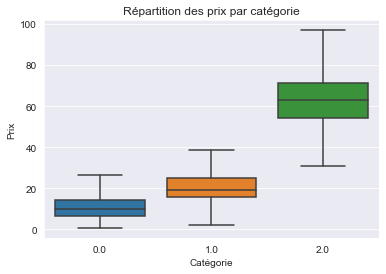

In [952]:
# Répétition du box plot de la partie Nettoyage
f = sns.boxplot(
    data=data, 
    x='Catégorie', 
    y='Prix',
    showfliers=False 
)
plt.title('Répartition des prix par catégorie')
plt.show(f)

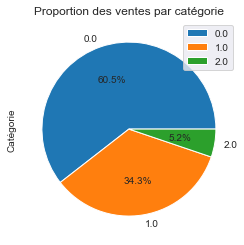

In [953]:
# Proportion des ventes par catégorie
a = data['Catégorie'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%'
)
plt.title('Proportion des ventes par catégorie')
plt.show(a)

In [954]:
# Indicateurs de la variable 'Prix'
indicateurs(data, 'Prix')

# --> Prix médian de toutes les transactions : 13.99

Indicateurs de position : 
Mode(s) : [15.99] (fréquence : 3.2 %) 
Moyenne : 17.4 
Médiane : 13.99 
1er quartile : 9.0 
3ème quartile : 19.0 
Indicateurs de dispersion : 
Minimum : 0.62 
Maximum : 300.0 
Étendue : 299.4 
Variance : 319.1 
Écart-type :  17.9 
Coeff. de variation : 1.0 
Skewness : 5.5 ( distribution étalée à droite ) 
Kurtosis : 45.4 ( distribution moins aplatie que la normale gaussienne )


In [955]:
# Dataset principal
# Indicateurs de la variable 'Prix', par catégorie
print(style.green + 'Dataset :' + style.bold, 'data', style.end, '\n')
indicateurs_bivaries(data, 'Catégorie', 'Prix')

Dataset : data  

Modalité : 0.0 (fréquence : 60.5 %)

Indicateurs de position : 
Mode(s) : [4.99] (fréquence : 4.4 %) 
Moyenne : 10.6 
Médiane : 9.99 
1er quartile : 6.3 
3ème quartile : 14.4 
Indicateurs de dispersion : 
Minimum : 0.62 
Maximum : 40.99 
Étendue : 40.4 
Variance : 24.3 
Écart-type :  4.9 
Coeff. de variation : 0.5 
Skewness : 0.4 ( distribution étalée à droite ) 
Kurtosis : -0.4 ( distribution plus aplatie que la normale gaussienne )


Modalité : 2.0 (fréquence : 5.2 %)

Indicateurs de position : 
Mode(s) : [68.99] (fréquence : 6.2 %) 
Moyenne : 75.2 
Médiane : 62.83 
1er quartile : 54.0 
3ème quartile : 71.2 
Indicateurs de dispersion : 
Minimum : 30.99 
Maximum : 300.0 
Étendue : 269.0 
Variance : 1536.2 
Écart-type :  39.2 
Coeff. de variation : 0.5 
Skewness : 2.3 ( distribution étalée à droite ) 
Kurtosis : 5.5 ( distribution moins aplatie que la normale gaussienne )


Modalité : 1.0 (fréquence : 34.3 %)

Indicateurs de position : 
Mode(s) : [15.99] (fréquence : 

In [956]:
# Dataset produits (analyse du stock)
# Indicateurs de la variable 'Prix', par catégorie
print(style.green + 'Dataset :' + style.bold, 'produits', style.end, '\n')
indicateurs_bivaries(produits, 'Catégorie', 'Prix')

Dataset : produits  

Modalité : 0 (fréquence : 70.2 %)

Indicateurs de position : 
Mode(s) : [4.99] (fréquence : 3.5 %) 
Moyenne : 11.7 
Médiane : 10.32 
1er quartile : 5.6 
3ème quartile : 16.6 
Indicateurs de dispersion : 
Minimum : -1.0 
Maximum : 40.99 
Étendue : 42.0 
Variance : 57.3 
Écart-type :  7.6 
Coeff. de variation : 0.6 
Skewness : 0.8 ( distribution étalée à droite ) 
Kurtosis : 0.3 ( distribution moins aplatie que la normale gaussienne )


Modalité : 1 (fréquence : 22.5 %)

Indicateurs de position : 
Mode(s) : [22.99, 32.99] (fréquence : 2.2 %) 
Moyenne : 25.5 
Médiane : 22.99 
1er quartile : 13.4 
3ème quartile : 34.0 
Indicateurs de dispersion : 
Minimum : 2.0 
Maximum : 80.99 
Étendue : 79.0 
Variance : 237.6 
Écart-type :  15.4 
Coeff. de variation : 0.6 
Skewness : 0.8 ( distribution étalée à droite ) 
Kurtosis : 0.3 ( distribution moins aplatie que la normale gaussienne )


Modalité : 2 (fréquence : 7.3 %)

Indicateurs de position : 
Mode(s) : [50.99, 68.99, 69.9

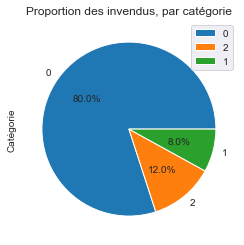

In [957]:
# Liste des produits invendus
invendus = produits[~produits['id_prod'].isin(data['id_prod'])]

# Proportion des catégories pour les invendus
a = invendus['Catégorie'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%'
)
plt.title('Proportion des invendus, par catégorie')
plt.show(a)

## Dates d'achat

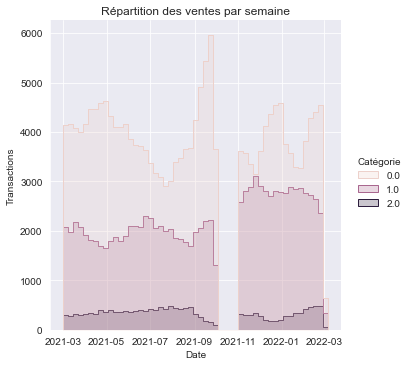

In [958]:
# Répartition des ventes par date et catégorie
g = sns.displot(data, x='Date', hue='Catégorie', binwidth=7, element='step')
g.set(ylabel='Transactions')
plt.title('Répartition des ventes par semaine')
plt.show(g)

# --> Catégorie 0 : pics aux mois mars, mai, septembre et décembre
# --> Catégorie 0 : pic du mois de septembre largement supérieur aux autres
# --> Catégorie 1 : pics modérés autour de l'été et des fêtes de fin d'année
# --> Catégorie 2 : chute des ventes après le mois de septembre

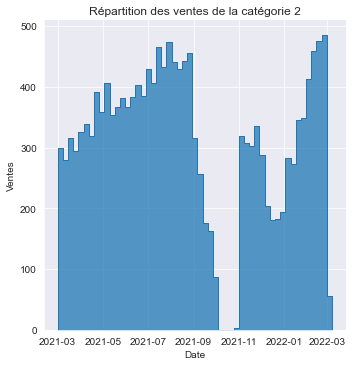

In [959]:
# Répartition des ventes de la catégorie 2, par date
g = sns.displot(
    data[data['Catégorie']==2], 
    x='Date', 
    binwidth=7, 
    element='step'
)
g.set(ylabel='Ventes')
plt.title('Répartition des ventes de la catégorie 2')
plt.show(g)

# Analyse : axe clients

## Distinction entre particuliers et professionnels
- 4 clients (sur 8500) agrégent à eux seuls 7% du chiffre d'affaires et des transactions
- Pour l'analyse, on dissocie la population en 2 groupes : ces 4 clients a priori professionnels, et les particuliers

In [960]:
# Agrégation des dépenses par client
depenses_par_clients = data.pivot_table(
    index='client_id', 
    values='Prix', 
    aggfunc='sum'
    ).sort_values(by='Prix', ascending=False).reset_index()
    
depenses_par_clients

# --> Les 4 premiers clients se démarquent nettement

,client_id,Prix
0,c_1609,150729.07
1,c_4958,137151.48
2,c_6714,69402.15
3,c_3454,52740.66
4,c_8026,2434.49
...,...,...
8593,c_8032,8.82
8594,c_890,6.08
8595,c_1675,5.57
8596,c_8114,4.99


In [961]:
# Échantillon ne contenant que les 4 gros clients
professionnels = data[data['client_id'].isin(
    depenses_par_clients.loc[0:3]['client_id'])]

# Échantillon excluant les 4 gros clients
particuliers = data.drop(professionnels.index)

# Proportion des transactions entre type de clients
print(
    style.bold + 'Proportions des échantillons :' + style.end, '\n'
    'Professionnels :',
    round((len(professionnels) / len(data) * 100), 1), '% des transactions\n'
    'Particuliers :',
    round((len(particuliers) / len(data) * 100), 1), '% des transactions'
)

Proportions des échantillons : 
Professionnels : 6.9 % des transactions
Particuliers : 93.1 % des transactions


In [962]:
# Chiffre d'affaires des 4 gros clients
ca_professionnels = professionnels['Prix'].sum()

# Chiffre d'affaires total
ca_total = data['Prix'].sum()

print(
    'Les 4 clients professionnels représentent',
    round((ca_professionnels / ca_total * 100), 1),
    '% du CA total'
)

# --> Les 4 clients représentent une part significative du CA
# --> Pour être juste, l'analyse doit être scindée en 2 échantillons de clients
# --> Les variables 'Sexe' et 'Naissance' ne seront pas analysées chez les professionnels

Les 4 clients professionnels représentent 7.5 % du CA total


## Clients professionnels

In [963]:
# Indicateurs bivariés sur 'Catégorie' et 'Prix'
indicateurs_bivaries(professionnels, 'Catégorie', 'Prix')

# --> Les professionnels achètent le plus fréquemment la catégorie 0

Modalité : 0.0 (fréquence : 59.7 %)

Indicateurs de position : 
Mode(s) : [4.99] (fréquence : 4.3 %) 
Moyenne : 10.7 
Médiane : 9.99 
1er quartile : 6.3 
3ème quartile : 14.4 
Indicateurs de dispersion : 
Minimum : 0.62 
Maximum : 39.99 
Étendue : 39.4 
Variance : 24.4 
Écart-type :  4.9 
Coeff. de variation : 0.5 
Skewness : 0.4 ( distribution étalée à droite ) 
Kurtosis : -0.4 ( distribution plus aplatie que la normale gaussienne )


Modalité : 1.0 (fréquence : 32.4 %)

Indicateurs de position : 
Mode(s) : [15.99] (fréquence : 4.4 %) 
Moyenne : 20.5 
Médiane : 19.44 
1er quartile : 15.8 
3ème quartile : 25.0 
Indicateurs de dispersion : 
Minimum : 2.0 
Maximum : 80.99 
Étendue : 79.0 
Variance : 56.9 
Écart-type :  7.5 
Coeff. de variation : 0.4 
Skewness : 1.9 ( distribution étalée à droite ) 
Kurtosis : 9.8 ( distribution moins aplatie que la normale gaussienne )


Modalité : 2.0 (fréquence : 7.8 %)

Indicateurs de position : 
Mode(s) : [68.99] (fréquence : 6.5 %) 
Moyenne : 75.8 


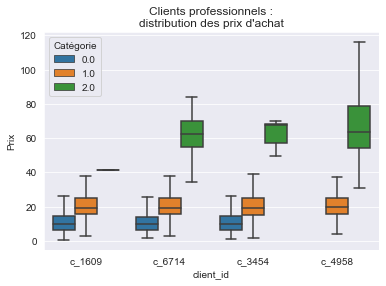

In [964]:
# Distribution des prix d'achat, par client
g = sns.boxplot(
    x='client_id',
    y='Prix',
    hue='Catégorie',
    data=professionnels,
    showfliers=False
)
plt.title('Clients professionnels :\ndistribution des prix d\'achat')
plt.show(g)

# --> Les 3 plus gros clients achètent en parts égales dans la catégorie 0
# --> Les 4 clients achètent en parts quasi-égales dans la catégorie 1
# --> Le 4ème client n'achète pas du tout dans la catégorie 0
# --> Le 4ème client consomme majoritairement la catégorie 2
# --> Le plus gros client n'achète quasiment rien dans la catégorie 2

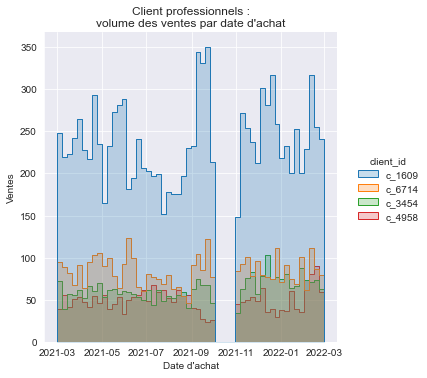

In [965]:
# Nombre de ventes, par date d'achat et client
g = sns.displot(
    professionnels, 
    x="Date",
    hue='client_id', 
    bins=54, # (1 classe = 1 semaine)
    element='step'
    )
g = (g.set_axis_labels(
    'Date d\'achat',
    'Ventes'
))
plt.title('Client professionnels :\nvolume des ventes par date d\'achat')
plt.show(g)

# --> Le plus gros client a un pic d'achat au mois de septembre
# --> Et un 2ème pic moins haut au mois de décembre

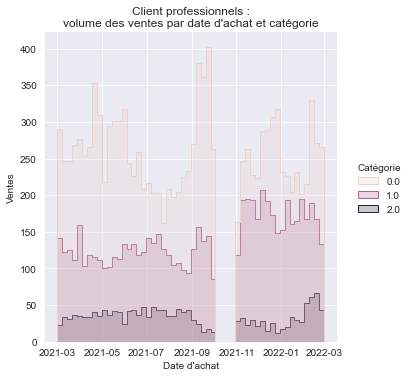

In [966]:
# Nombre de ventes, par date d'achat et catégorie
g = sns.displot(
    professionnels, 
    x="Date",
    hue='Catégorie', 
    bins=54, # (1 classe = 1 semaine)
    element='step'
    )
g = (g.set_axis_labels(
    'Date d\'achat',
    'Ventes'
))
plt.title('Client professionnels :\nvolume des ventes par date d\'achat et catégorie')
plt.show(g)

# --> Catégorie 0 : pic d'achat au mois de septembre, correspondant au plus gros client
# --> Catégorie 1 : pic d'achat autour des fêtes de fin d'année

## Clients particuliers

### Par sexe
- les femmes achètent très légèrement plus que les hommes
- les proportions de vente sont les mêmes pour chaque catégorie, avec les mêmes indicateurs de prix
- les 2 groupes achètent autant à chaque moment de l'année
- les années de naissance se répartissent de la même manière chez les hommes et chez les femmes
- Le sexe n'indique aucune typologie de clients particulière 

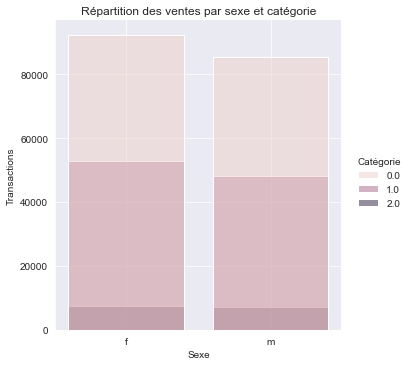

In [967]:
# Ventes et catégories, par sexe
g = sns.displot(particuliers, x="Sexe", hue='Catégorie', shrink=.8)
g.set(ylabel='Transactions')
plt.title('Répartition des ventes par sexe et catégorie')
plt.show(g)

# --> Les 2 sexes ont le même volume d'achats
# --> Les 2 sexes achètent autant dans chaque catégorie

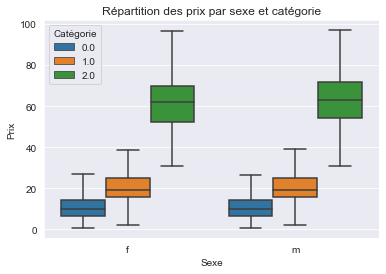

In [968]:
# Répartition des prix d'achat, par sexe
g = sns.boxplot(
    data=particuliers, 
    x="Sexe", 
    y='Prix', 
    hue='Catégorie',
    showfliers=False
)

plt.title('Répartition des prix par sexe et catégorie')
plt.show(g)

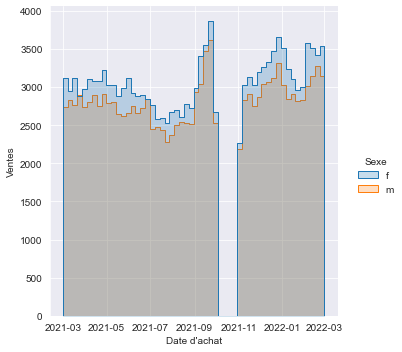

In [969]:
# Sexe / Date d'achat
g = sns.displot(
    data=particuliers, 
    x="Date", 
    hue='Sexe', 
    bins=54, # (1 classe = 1 semaine)
    element='step'
    )
g = (g.set_axis_labels(
    'Date d\'achat',
    'Ventes'
))
plt.show(g)

# Les histogrammes des 2 sexes ont les mêmes formes
# Les 2 groupes achètent autant aux mêmes périodes de l'année

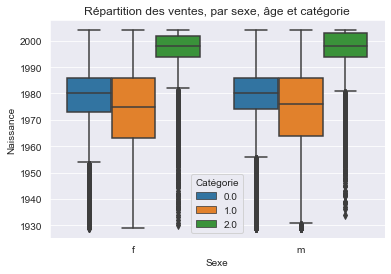

In [970]:
# Répartition des ventes, par âge et par sexe
g = sns.boxplot(
    data=particuliers, 
    x="Sexe", 
    y='Naissance',
    hue='Catégorie'
    # showfliers=False
)

plt.title('Répartition des ventes, par sexe, âge et catégorie')
plt.show(g)

# --> Les années se répartissent de la même façon pour les 2 sexes

### Par âge
- La catégorie 1 n'est pas corrélée à l'âge
- Les 2 autres catégories ont un lien avec l'âge
    - L'âge des clients de la catégorie 2 se démarque nettement (nés aux environs de 2000)
- L'âge n'est pas corrélé à la date d'achat

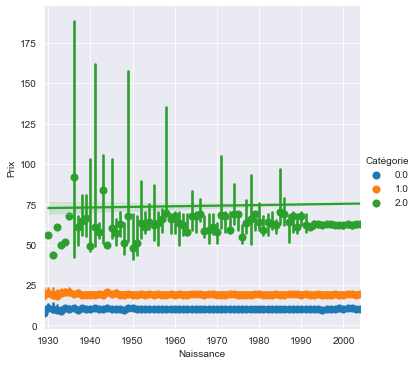

In [971]:
# Régression linéaire entre 'Naissance' et 'Prix'
g = sns.lmplot(
    data=particuliers, 
    x="Naissance",
    y='Prix',
    hue='Catégorie',
    x_estimator=np.median
    )

plt.show(g)

# --> Il y a a priori une corrélation entre l'âge et le prix d'achat médian

In [972]:
# Indicateurs de la variable 'Naissance', par catégorie
indicateurs_bivaries(particuliers, 'Catégorie', 'Naissance')

# --> Cat. 0 : médiane et moyenne autour de 1980
# --> Cat. 1 : clients légèrement plus âgés que la cat.0 (d'environ 5 ans)
# --> Cat. 2 :
# -->     Fréquence du mode (2004) importante (18%)
# -->     Indicateurs autour de l'année 2000
# -->     Kurtosis de la catégorie est lui aussi très marqué

# --> Écarts-types de 10 ans pour les catégories 0 et 2, 15 ans pour la cat. 1
# -->     Individus à tendance plus âgée pour la cat. 1
# -->     L'âge des individus de la cat. 2 se détache des autres 

Modalité : 0.0 (fréquence : 60.6 %)

Indicateurs de position : 
Mode(s) : [1988] (fréquence : 4.9 %) 
Moyenne : 1978.2 
Médiane : 1980.0 
1er quartile : 1974.0 
3ème quartile : 1986.0 
Indicateurs de dispersion : 
Minimum : 1929 
Maximum : 2004 
Étendue : 75 
Variance : 132.6 
Écart-type :  11.5 
Coeff. de variation : 0.0 
Skewness : -1.0 ( distribution étalée à gauche ) 
Kurtosis : 1.6 ( distribution moins aplatie que la normale gaussienne )


Modalité : 2.0 (fréquence : 5.0 %)

Indicateurs de position : 
Mode(s) : [2004] (fréquence : 18.5 %) 
Moyenne : 1996.3 
Médiane : 1998.0 
1er quartile : 1994.0 
3ème quartile : 2002.0 
Indicateurs de dispersion : 
Minimum : 1930 
Maximum : 2004 
Étendue : 74 
Variance : 92.6 
Écart-type :  9.6 
Coeff. de variation : 0.0 
Skewness : -3.0 ( distribution étalée à gauche ) 
Kurtosis : 11.1 ( distribution moins aplatie que la normale gaussienne )


Modalité : 1.0 (fréquence : 34.4 %)

Indicateurs de position : 
Mode(s) : [1979] (fréquence : 2.8 %) 
M

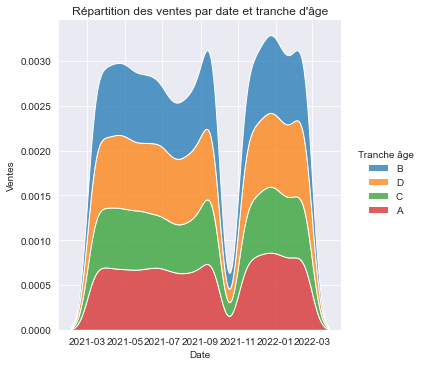

In [973]:
g = sns.displot(
    data=particuliers, 
    x='Date', 
    hue='Tranche âge', 
    kind='kde', 
    multiple='stack')
g.set(ylabel='Ventes')
plt.title('Répartition des ventes par date et tranche d\'âge')
plt.show(g)

# --> Les 4 quartiles d'âge achètent autant à chaque moment de l'année

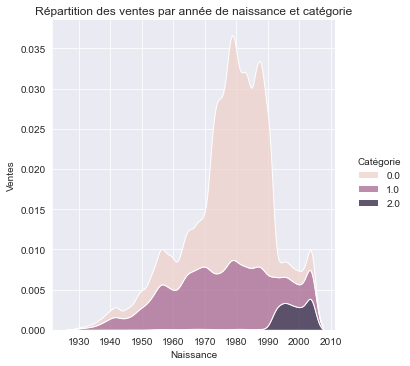

In [974]:
g = sns.displot(
    data=particuliers, 
    x='Naissance', 
    hue='Catégorie', 
    kind='kde', 
    multiple='stack'
)
g.set(ylabel='Ventes')
plt.title('Répartition des ventes par année de naissance et catégorie')
plt.show(g)

# --> Les catégories 0 et 1 ont les mêmes formes d'histogramme
# --> Excepté un pic autour de 1980 pour la catégorie 0
# --> La catégorie 2 est majoritairement achetée par des clients nés après 1990

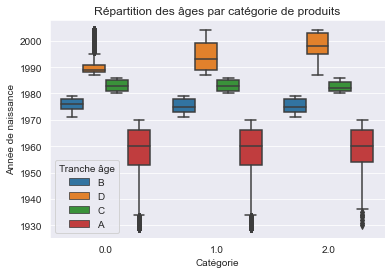

In [975]:
# Corrélation entre 'Catégorie' et 'Naissance'
e = sns.boxplot(data=particuliers, x='Catégorie', y='Naissance', hue='Tranche âge')
e.set(xlabel='Catégorie', ylabel='Année de naissance')
plt.title('Répartition des âges par catégorie de produits')
plt.show(e)

# --> Certaines années de naissance sont plus corrélées que d'autres à certaines catégories
# --> Les individus entre Q1 et Q2 sont plus susceptibles d'acheter les catégories 0, voire 1

# Conclusions


# Rééquilibrer les catégories

**Augmenter l'offre dans la catégorie 1**
Proportionnellement au stock, cette catégorie se vend beaucoup plus que la catégorie 0, pourtant plus abordable financièrement.

**Réduire le nombre de références dans la catégorie 0**